In [3]:
%matplotlib inline
import sys
sys.version

'3.7.9 (default, Jan 24 2021, 23:57:56) \n[GCC 10.2.0]'

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize
import json

In [23]:
filename = "data/2021-05-09T23:17:38_inv_smtest.json"

In [24]:
data = pd.read_json(filename)

In [7]:
dict_for_colors = {}
get_counter_of_pid_list = []
available_colors = ['g','r','c','m','y','k']*10
#available_colors = ['b','g','r','c','m','y','k','tab:blue','tab:orange','tab:green','tab:purple','tab:brown',
#                   'b','g','r','c','m','y','k','tab:blue','tab:orange','tab:green','tab:purple','tab:brown',
#                   'b','g','r','c','m','y','k','tab:blue','tab:orange','tab:green','tab:purple','tab:brown',
#                   'b','g','r','c','m','y','k','tab:blue','tab:orange','tab:green','tab:purple','tab:brown']
def assign_color_to_hostname_pid(hostname, pid) -> str:
    key = hostname + pid
    if not key in dict_for_colors:
        dict_for_colors[key] = available_colors[len(dict_for_colors)]
    return dict_for_colors[key]

def get_counter_of_pid(pid) -> int:
    try:
        val =  get_counter_of_pid_list.index(pid)
        return val
    except Exception:
        get_counter_of_pid_list.append(pid)
        return get_counter_of_pid_list.index(pid)

In [8]:
invokes = []
com_starts = []
com_ends = []
ends = []
pids = []
accelerator_colors = []
infs_ms = []
failed_invocations = []
pid_counter = []
for index, row in data.sort_values(by=['start']).iterrows():
    if row.end == -1:
        failed_invocations.append(row)
        continue
    invokes.append(row.start)
    ends.append(row.end)
    com_starts.append(int(row.result['start_computation']))
    com_ends.append(int(row.result['end_computation']))
    pids.append(int(row.result['pid']))
    infs_ms.append(row.result['metadata']['inference_ms'])
    accelerator_colors.append(assign_color_to_hostname_pid(row.result['metadata']['hostname'], row.result['pid']))
    pid_counter.append(get_counter_of_pid(row.result['pid']))
indices = range(len(invokes))
print(f"Number of failed invocations: {len(failed_invocations)}")

Number of failed invocations: 0


Used Runtime Instances and when they were active


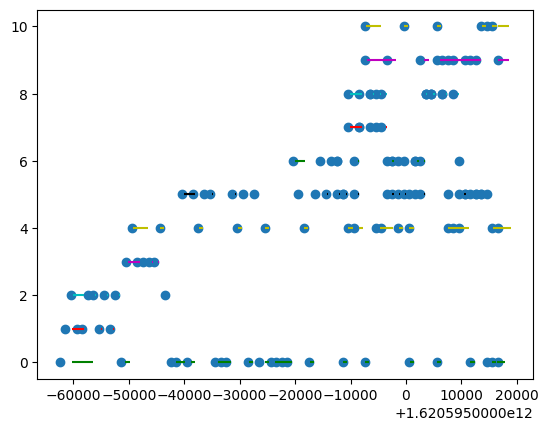

In [9]:
#plt.hlines(y=[i-0.2 for i in pid_counter], xmin=invokes, xmax=ends)
plt.hlines(y=pid_counter, xmin=com_starts, xmax=com_ends, colors=accelerator_colors, linestyle="solid")
plt.scatter(invokes, pid_counter)
print("Used Runtime Instances and when they were active")


y=sequentially numbered invocations; blueDot=creation timestamp of invocation; line=working time (color=pid-code)


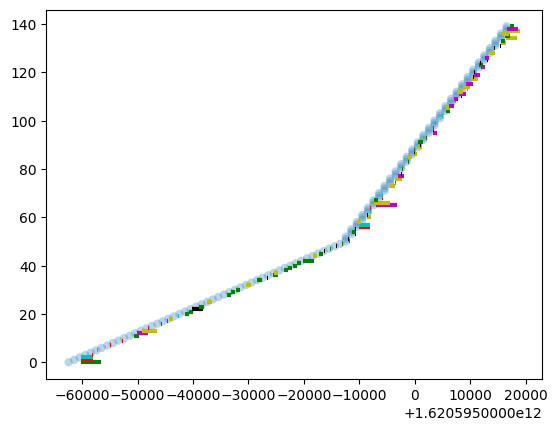

In [10]:
plt.scatter(invokes, indices, alpha=0.3, linewidths=0.2, edgecolors='none')
plt.hlines(y=indices, xmin=com_starts, xmax=com_ends, color=accelerator_colors, lw=3)
print("y=sequentially numbered invocations; blueDot=creation timestamp of invocation; line=working time (color=pid-code)")


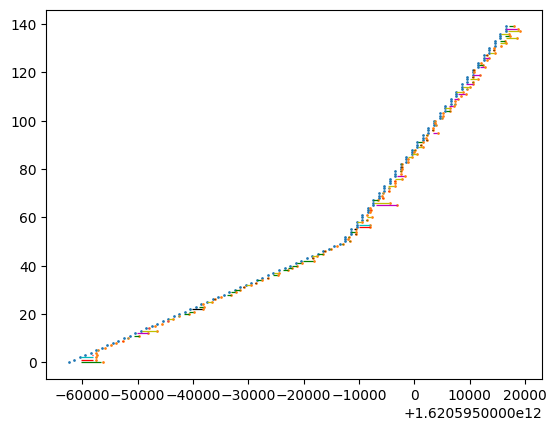

In [11]:
s = 0.9
plt.scatter(invokes, indices, s=s)
plt.hlines(y=indices, xmin=com_starts, xmax=com_ends, color=accelerator_colors, lw=s)
plt.scatter(ends, indices, s=s)
plt.savefig("invokeview.svg")

In [12]:
print(f'Inference: mean={np.mean(infs_ms)}, std={np.std(infs_ms)}')

Inference: mean=519.2499893052237, std=521.589079111392


In [13]:
dur=np.array(ends)-np.array(invokes)
print(f'Total Duration: mean={np.mean(dur)}, std={np.std(dur)}')

Total Duration: mean=1148.0785714285714, std=850.7203843790033


In [14]:
com=np.array(com_ends)-np.array(com_starts)
print(f'Total Computation (inference+upload): mean={np.mean(com)}, std={np.std(com)}')

Total Computation (inference+upload): mean=605.8071428571428, std=714.7509945671246


In [15]:
tts=np.array(com_starts)-np.array(invokes)
print(f'Time from invocation to start_computation: mean={np.mean(tts)}, std={np.std(tts)}')

Time from invocation to start_computation: mean=478.07142857142856, std=335.2559926567233


In [16]:
babylon = {
    'invokes': [],
    'com_starts': [],
    'com_ends': [],
    'ends': [],
    'pids': [],
    'accelerator_colors': [],
    'infs_ms': [],
    'pid_counter': [],
}
sandybridge_ep = {
    'invokes': [],
    'com_starts': [],
    'com_ends': [],
    'ends': [],
    'pids': [],
    'accelerator_colors': [],
    'infs_ms': [],
    'pid_counter': [],
}

for index, row in data.sort_values(by=['start']).iterrows():
    if row.end == -1:
        continue
        
    use_dict = {}
    if row.result['metadata']['hostname'] == 'sandybridge-ep':
        use_dict = sandybridge_ep
    else:
        use_dict = babylon
    use_dict["invokes"].append(row.start)
    use_dict["ends"].append(row.end)
    use_dict["com_starts"].append(int(row.result['start_computation']))
    use_dict["com_ends"].append(int(row.result['end_computation']))
    use_dict["pids"].append(int(row.result['pid']))
    use_dict["infs_ms"].append(row.result['metadata']['inference_ms'])
    use_dict["accelerator_colors"].append(assign_color_to_hostname_pid(row.result['metadata']['hostname'], row.result['pid']))
    use_dict["pid_counter"].append(get_counter_of_pid(row.result['pid']))

In [17]:
print("Results for babylon, sandybridge-ep:")
for use_dict in [babylon, sandybridge_ep]:
    print(f'Total Invocations: {len(use_dict["invokes"])}')
    print(f'Inference: mean={np.mean(use_dict["infs_ms"])}, std={np.std(use_dict["infs_ms"])}')
    dur=np.array(use_dict["ends"])-np.array(use_dict["invokes"])
    print(f'Total Duration: mean={np.mean(dur)}, std={np.std(dur)}')
    com=np.array(use_dict["com_ends"])-np.array(use_dict["com_starts"])
    print(f'Total Computation (inference+upload): mean={np.mean(com)}, std={np.std(com)}')
    tts=np.array(use_dict["com_starts"])-np.array(use_dict["invokes"])
    print(f'Time from invocation to start_computation: mean={np.mean(tts)}, std={np.std(tts)}')
    print()

Results for babylon, sandybridge-ep:
Total Invocations: 83
Inference: mean=196.04946044554194, std=295.8766961369302
Total Duration: mean=843.277108433735, std=648.8256177487604
Total Computation (inference+upload): mean=272.4698795180723, std=521.7104015338972
Time from invocation to start_computation: mean=527.1204819277109, std=270.3641184928992

Total Invocations: 57
Inference: mean=989.8753208026551, std=408.82293586292315
Total Duration: mean=1591.9122807017543, std=912.3063366843659
Total Computation (inference+upload): mean=1091.1929824561403, std=678.9952184054175
Time from invocation to start_computation: mean=406.64912280701753, std=401.2708535862367



In [34]:
with open(filename) as f:
    d = json.load(f)
ndata = json_normalize(d)

In [36]:
ndata.columns

Index(['end', 'start', 'inv.configuration', 'inv.params.callbackUrl',
       'inv.params.payload', 'inv.params.payload_reference.bucket.accessKey',
       'inv.params.payload_reference.bucket.bucketName',
       'inv.params.payload_reference.bucket.endpoint',
       'inv.params.payload_reference.bucket.secretKey',
       'inv.params.payload_reference.file', 'inv.params.payload_type',
       'inv.params.resultBucket.accessKey',
       'inv.params.resultBucket.bucketName',
       'inv.params.resultBucket.endpoint', 'inv.params.resultBucket.secretKey',
       'inv.runtime', 'result.accelerator', 'result.amount',
       'result.end_computation', 'result.metadata.inference_ms',
       'result.metadata.hostname', 'result.metadata.start',
       'result.metadata.end', 'result.pid', 'result.request', 'result.result',
       'result.result_type', 'result.start_computation'],
      dtype='object')

<AxesSubplot:xlabel='start', ylabel='end'>

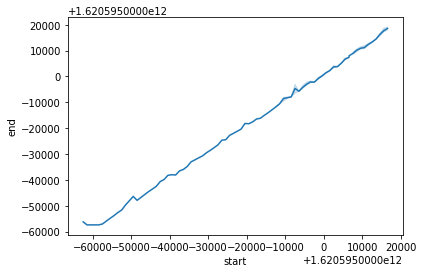

In [37]:
sns.lineplot(data=ndata, x="start", y="end")